<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as vutils
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (0.5 балла)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/file/d/1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x/view?usp=drive_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """

  transform = tt.Compose([
      tt.Resize(image_size),
      tt.ToTensor(),
      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

  dataset = ImageFolder(root='/content/drive/MyDrive/', transform=transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return loader

In [21]:
image_size = 128
batch_size = 16

loader = get_dataloader(128,16)
train_loader = DeviceDataLoader(loader, device)

#TODO: build dataloader and transfer it to device

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
base_channels = 32

In [ ]:
discriminator = nn.Sequential(


    nn.Conv2d(3, base_channels, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(base_channels),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(base_channels, base_channels*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(base_channels*2),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(base_channels*2, base_channels*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(base_channels*4),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(base_channels*4, base_channels*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(base_channels*8),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(base_channels*8, base_channels*16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(base_channels*16),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(base_channels*16, 1, kernel_size=4, stride=1, padding=0, bias=False),


    nn.Flatten())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [ ]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
epochs = 30

model = {
    "discriminator": discriminator,
    "generator": generator
}

In [ ]:
def gradient_penalty(critic, real_images, fake_images, device='cuda'):
    # Получаем случайное альфа значение для интерполяции
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device)

    # Интерполируем между реальными и фейковыми изображениями
    interpolated = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

    # Прогоняем через критику
    pred = critic(interpolated)

    # Генерация единичных градиентов для вычисления производных
    grad_outputs = torch.ones_like(pred)

    # Вычисление градиентов
    gradients = torch.autograd.grad(
        outputs=pred,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Преобразуем градиенты в 2D для вычисления нормы
    gradients = gradients.view(gradients.size(0), -1)

    # Нормируем градиенты
    gradient_norm = gradients.norm(2, dim=1)

    # Градиентный штраф
    gp = ((gradient_norm - 1) ** 2).mean()

    # Возвращаем штраф (если нужно, можно добавить минимальную норму, чтобы избежать деления на 0)
    return gp


In [ ]:
def fit(model, epochs, lr_d=0.0002, lr_g=0.0001, n_critic=5, lambda_gp=10):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g, losses_d = [], []
    real_scores, fake_scores = [], []

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr_d, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr_g, betas=(0.5, 0.999))
    }

    for epoch in tqdm(range(epochs)):
        loss_d_per_epoch, loss_g_per_epoch = [], []
        real_score_per_epoch, fake_score_per_epoch = [], []

        for real_images, _ in tqdm(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # === Train Critic ===
            for _ in range(n_critic):
                z = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = model["generator"](z).detach()

                real_preds = model["discriminator"](real_images)
                fake_preds = model["discriminator"](fake_images)

                gp = gradient_penalty(model["discriminator"], real_images, fake_images, device)
                d_loss = fake_preds.mean() - real_preds.mean() + lambda_gp * gp

                nn.utils.clip_grad_norm_(model["discriminator"].parameters(), max_norm=1.0)

                optimizer["discriminator"].zero_grad()
                d_loss.backward()
                optimizer["discriminator"].step()

                loss_d_per_epoch.append(d_loss.item())
                real_score_per_epoch.append(real_preds.mean().item())
                fake_score_per_epoch.append(fake_preds.mean().item())

            # === Train Generator ===
            z = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](z)
            g_loss = -model["discriminator"](fake_images).mean()

            optimizer["generator"].zero_grad()
            g_loss.backward()
            optimizer["generator"].step()

            loss_g_per_epoch.append(g_loss.item())

        # Logging
        losses_d.append(np.mean(loss_d_per_epoch))
        losses_g.append(np.mean(loss_g_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Loss_D: {losses_d[-1]:.4f} | Loss_G: {losses_g[-1]:.4f} | "
              f"Real_Score: {real_scores[-1]:.4f} | Fake_Score: {fake_scores[-1]:.4f}")

        sample_dir = 'samples'
        os.makedirs(sample_dir, exist_ok=True)
        with torch.no_grad():
            z = torch.randn(64, latent_size, 1, 1, device=device)
            fake_images = model["generator"](z)
            fake_images = (fake_images + 1) / 2  # денормализация от [-1,1] к [0,1]
            grid = vutils.make_grid(fake_images, nrow=8, padding=2, normalize=False)
            vutils.save_image(grid, os.path.join(sample_dir, f"fake_images_epoch_{epoch+1:03d}.png"))
        plot_loss(losses_d,losses_g)
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
def plot_loss(losses_d, losses_g):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_d, label='Discriminator')
    plt.plot(losses_g, label='Generator')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("WGAN-GP Losses")
    plt.legend()
    plt.grid()
    plt.savefig("loss_plot.png")
    plt.close()


In [22]:
history = fit(model, epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/30] | Loss_D: -931.7616 | Loss_G: 519.2491 | Real_Score: 435.9448 | Fake_Score: -512.4243


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/30] | Loss_D: -254.7629 | Loss_G: 1153.5138 | Real_Score: -876.5329 | Fake_Score: -1151.9962


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/30] | Loss_D: -24.7783 | Loss_G: 1050.8057 | Real_Score: -1013.0477 | Fake_Score: -1047.3844


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/30] | Loss_D: -27.5008 | Loss_G: 972.3903 | Real_Score: -931.5155 | Fake_Score: -969.4853


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/30] | Loss_D: -26.6920 | Loss_G: 929.8603 | Real_Score: -891.0783 | Fake_Score: -927.6943


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/30] | Loss_D: -27.6168 | Loss_G: 899.9047 | Real_Score: -860.2750 | Fake_Score: -898.0353


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/30] | Loss_D: -27.3179 | Loss_G: 875.5642 | Real_Score: -836.5242 | Fake_Score: -873.7412


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/30] | Loss_D: -26.6599 | Loss_G: 852.2420 | Real_Score: -813.7318 | Fake_Score: -849.7355


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/30] | Loss_D: -26.8143 | Loss_G: 845.2354 | Real_Score: -806.6346 | Fake_Score: -842.6375


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/30] | Loss_D: -26.8763 | Loss_G: 837.1898 | Real_Score: -798.4432 | Fake_Score: -834.4622


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/30] | Loss_D: -25.8880 | Loss_G: 830.4365 | Real_Score: -793.1439 | Fake_Score: -827.6686


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/30] | Loss_D: -25.2769 | Loss_G: 816.4778 | Real_Score: -780.5273 | Fake_Score: -814.0771


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/30] | Loss_D: -24.9142 | Loss_G: 804.6845 | Real_Score: -768.9311 | Fake_Score: -802.0040


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/30] | Loss_D: -24.4948 | Loss_G: 790.6860 | Real_Score: -756.0829 | Fake_Score: -788.4208


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/30] | Loss_D: -23.3062 | Loss_G: 779.6132 | Real_Score: -746.6089 | Fake_Score: -777.3519


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/30] | Loss_D: -22.0773 | Loss_G: 764.3205 | Real_Score: -732.8682 | Fake_Score: -761.8521


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/30] | Loss_D: -21.3221 | Loss_G: 752.1187 | Real_Score: -722.0413 | Fake_Score: -750.2074


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/30] | Loss_D: -19.7471 | Loss_G: 734.8213 | Real_Score: -707.1049 | Fake_Score: -732.6371


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/30] | Loss_D: -20.0779 | Loss_G: 727.9109 | Real_Score: -699.1957 | Fake_Score: -725.4131


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/30] | Loss_D: -19.0411 | Loss_G: 717.0591 | Real_Score: -689.5968 | Fake_Score: -714.4242


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/30] | Loss_D: -17.3457 | Loss_G: 697.0117 | Real_Score: -672.2081 | Fake_Score: -694.7263


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/30] | Loss_D: -17.4084 | Loss_G: 679.0620 | Real_Score: -654.4791 | Fake_Score: -676.9389


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/30] | Loss_D: -17.8937 | Loss_G: 672.5218 | Real_Score: -647.0703 | Fake_Score: -670.2971


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/30] | Loss_D: -17.3160 | Loss_G: 660.2310 | Real_Score: -635.4516 | Fake_Score: -658.0562


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/30] | Loss_D: -16.3419 | Loss_G: 634.8817 | Real_Score: -612.1398 | Fake_Score: -632.8082


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/30] | Loss_D: -18.3268 | Loss_G: 632.0802 | Real_Score: -605.6056 | Fake_Score: -629.4733


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/30] | Loss_D: -15.0707 | Loss_G: 616.8303 | Real_Score: -595.7190 | Fake_Score: -615.2503


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/30] | Loss_D: -17.2594 | Loss_G: 601.0132 | Real_Score: -576.9218 | Fake_Score: -599.1244


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/30] | Loss_D: -16.8508 | Loss_G: 593.5634 | Real_Score: -569.8988 | Fake_Score: -591.7093


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/30] | Loss_D: -14.3686 | Loss_G: 579.7750 | Real_Score: -559.6992 | Fake_Score: -578.0368


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [23]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [24]:
def show_images(generated):
    # Denormalize the images from [-1, 1] to [0, 1]
    generated = (generated + 1) / 2  # Это требуется, если изображения в диапазоне [-1, 1]

    # Сохраняем изображения в grid для отображения
    grid = vutils.make_grid(generated, nrow=2, padding=2, normalize=False)

    # Показать сгенерированные изображения
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Переводим тензор в формат numpy для matplotlib
    plt.axis('off')
    plt.show()

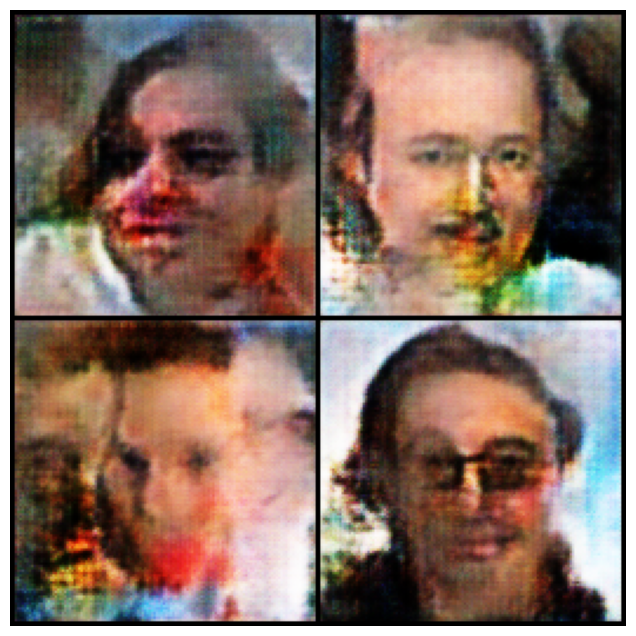

In [25]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (1.5 балл)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Генерация фейковых изображений для каждого батча
def generate_fake_images(batch_size, model, latent_size, device):
    fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = model["generator"](fixed_latent)
    return fake_images

# Преобразование изображений в формат, удобный для классификатора
def preprocess_images(images, device):
    images = images.cpu().detach().numpy()  # Переводим на CPU и в NumPy
    images = images.reshape(images.shape[0], -1)  # Преобразуем изображения в вектор
    return images

# Реализация Leave-One-Out Cross-Validation
def loo_evaluation(train_loader, model, latent_size, device):
    # Списки для реальных и фейковых изображений
    real_images_list = []
    fake_images_list = []

    # Проход по всем батчам в train_loader
    for real_images, _ in tqdm(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Генерация фейковых изображений
        fake_images = generate_fake_images(batch_size, model, latent_size, device)

        # Добавление реальных и фейковых изображений в списки
        real_images_list.append(real_images)
        fake_images_list.append(fake_images)

    # Преобразование всех реальных и фейковых изображений в один массив
    real_images = torch.cat(real_images_list, dim=0)
    fake_images = torch.cat(fake_images_list, dim=0)

    # Преобразуем изображения в формат для классификатора
    X_real = preprocess_images(real_images, device)
    X_fake = preprocess_images(fake_images, device)

    X = np.concatenate([X_real, X_fake], axis=0)
    y = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_fake.shape[0])], axis=0)

    # Стандартизируем данные
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Инициализация LeaveOneOut
    loo = LeaveOneOut()
    accuracy_scores = []

    # Применение Leave-One-Out
    for train_index, test_index in tqdm(loo.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Обучение KNN классификатора
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(X_train, y_train)

        # Прогнозирование и вычисление точности
        y_pred = clf.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred))

    # Возвращаем среднюю точность
    mean_accuracy = np.mean(accuracy_scores)
    return mean_accuracy

# Пример использования:
# train_loader - это DataLoader, который уже содержит реальные изображения
# model - словарь, содержащий генератор




In [ ]:
# Пример использования:
# train_loader - это DataLoader, который уже содержит реальные изображения
# model - словарь, содержащий генератор
latent_size = 128  # Размер латентного пространства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Пример на фиктивных данных (не забудь заменить их на реальные данные)
model = {
    "generator": generator,  # Модель генератора
}  # Здесь должна быть твоя модель генератора

# Оценка с помощью Leave-One-Out Cross-Validation
accuracy = loo_evaluation(train_loader, model, latent_size, device)
print(f"Leave-One-Out Cross-Validation Accuracy: {accuracy:.4f}")


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (1 балл)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [27]:
from sklearn.manifold import TSNE

def visualize_tsne(train_loader, model, latent_size, device):
    real_images_list = []
    fake_images_list = []

    # Проход по всем батчам в train_loader
    for real_images, _ in tqdm(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Генерация фейковых изображений
        fake_images = generate_fake_images(batch_size, model, latent_size, device)

        # Добавление реальных и фейковых изображений в списки
        real_images_list.append(real_images)
        fake_images_list.append(fake_images)

    # Преобразование всех реальных и фейковых изображений в один массив
    real_images = torch.cat(real_images_list, dim=0)
    fake_images = torch.cat(fake_images_list, dim=0)

    # Преобразуем изображения в формат для t-SNE
    X_real = preprocess_images(real_images, device)
    X_fake = preprocess_images(fake_images, device)

    # Объединение реальных и фейковых изображений
    X = np.concatenate([X_real, X_fake], axis=0)
    y = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_fake.shape[0])], axis=0)

    # Применение t-SNE для уменьшения размерности
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Визуализация с использованием matplotlib
    plt.figure(figsize=(10, 8))
    plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], color='blue', label='Real', alpha=0.5)
    plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color='red', label='Fake', alpha=0.5)
    plt.title('t-SNE visualization of Real vs Fake Images')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

  0%|          | 0/197 [00:00<?, ?it/s]

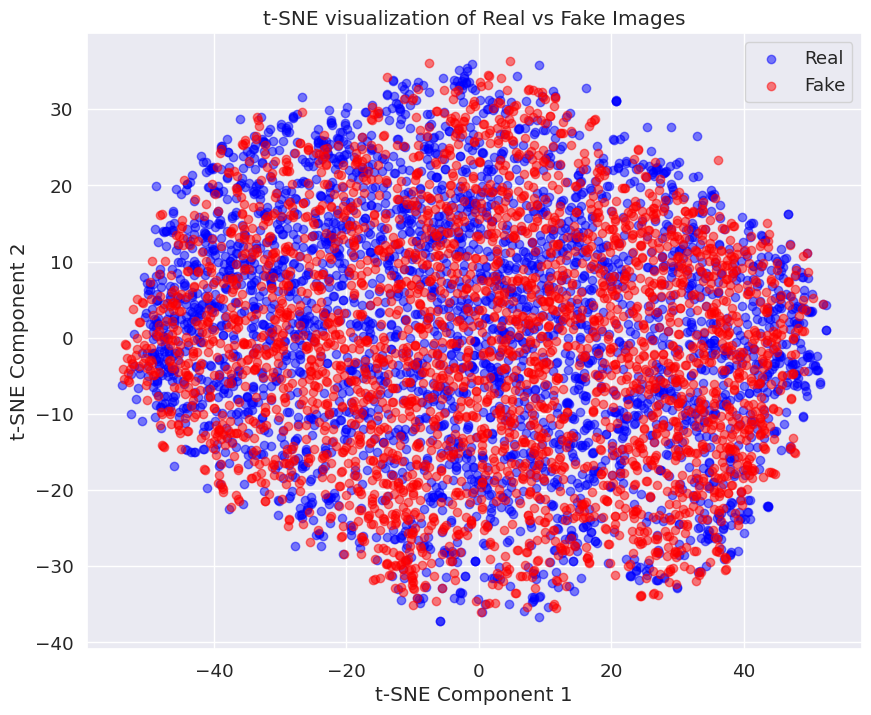

In [28]:
visualize_tsne(train_loader, model, latent_size, device)

Прокомментируйте получившийся результат: